<a href="https://colab.research.google.com/github/urosgodnov/juypterNotebooks/blob/main/DataMining/Machine_Learning_with_Python_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using Python to implement machine learning process
by dr. Uros Godnov**

# Data exploration

In [ ]:
import pandas as pd

from google.colab import drive
import sys
# Mount google drive
drive.mount('/content/gdrive')
# Changing path dirctory
sys.path.append('/content/gdrive/MyDrive/Google_Colab_modules')

import sweetviz as sv
import ydata_profiling as ydp

In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/urosgodnov/datasets/refs/heads/master/laptop_price_with_missing_values.csv")


In [ ]:
df.head()

**changing pandas behavior**

In [ ]:
pd.set_option('display.max_rows', 20)         # Show up to 20 rows
pd.set_option('display.max_columns', 10)      # Show up to 10 columns
pd.set_option('display.precision', 3)         # Set float precision to 3 decimals
pd.set_option('display.max_colwidth', 50)     # Limit column width to 50 characters


## Basic data overview

**datatable formatter**

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
## displying data types
df.dtypes

In [ ]:
df.describe() # basic descriptive statistics

In [ ]:
# displaying missing values statistics
df.isnull().sum()

In [ ]:
## displaying skewness
df.select_dtypes(include="number").skew()

In [ ]:
## displying frequencies
df['Company'].value_counts()

In [ ]:
# displying histograms
df.hist(figsize=(15,10))

## Automatic data exploration

- ydata_profiling (pandas_profiling)
- sweetviz

In [ ]:
ydp.ProfileReport(df)

In [ ]:
import sweetviz as sv

In [ ]:
# report = sv.analyze(df)

In [ ]:
# report.show_html()

In [ ]:
# targeting dependent variable
# report = sv.analyze(df, target_feat='Price (Euro)')
# report.show_html()

In [ ]:
# problem with missing values
# for the demo, remove missing values from dependent variable
df_droped=df.dropna(subset=['Price (Euro)'])
report = sv.analyze(df, target_feat='Price (Euro)')
report.show_html()

# Missing data strategies

Remove missing data:
- Use dropna() to remove rows or columns with missing values.
- Fill missing data: Use fillna() to fill missing values with a specific value or a calculated statistic like mean or median.
- Interpolation: For numerical data, use interpolate() to estimate missing values.

## Removing missing values

In [ ]:
missing_percentage = (len(df) - df.count()) / len(df) * 100

# Sort the missing percentages in descending order (most missing values first)
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

sorted_missing_percentage

In [ ]:
df_droped = df.dropna()

missing_percentage = (len(df_droped) - df_droped.count()) / len(df_droped) * 100

# Sort the missing percentages in descending order (most missing values first)
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

sorted_missing_percentage

**But we cannot just remove missing data, if there is a pattern. We should check if data is Missing Completly At Random (MCAR Little test).**

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

def test_mcar(data):
    # Remove rows where all values are missing
    data = data.dropna(how='all')

    # Get the number of rows and columns in the data
    n, p = data.shape

    # Create a missing data indicator matrix
    missing_data = data.isnull().astype(int)

    # Mean of the missing data indicators for each variable
    missing_mean = missing_data.mean(axis=0)

    # Overall mean of the missing data indicators
    overall_mean = missing_data.mean().mean()

    # Compute expected value of missing data indicators for each row
    row_means = missing_data.mean(axis=1)

    # Compute the statistic for the test
    chi_squared = ((row_means - overall_mean) ** 2).sum() * (n * p / (p * overall_mean * (1 - overall_mean)))

    # Compute degrees of freedom
    degrees_of_freedom = (n - 1) * (p - 1)

    # Compute the p-value for the test
    p_value = 1 - stats.chi2.cdf(chi_squared, degrees_of_freedom)

    return chi_squared, p_value

 If the p-value is large, it suggests the missing data might be MCAR, whereas **a small p-value** suggests the missingness may **depend** on observed or unobserved data.

In [ ]:
print(f"The p value of test is {test_mcar(df)[1]}, which means data is not missing completly at random. We must impute data.")

## Fill missing values

For the data manipulation to be simpler, we should change the columns' name to simpler format. Currently the pyjanitor module doesnt work in Google Colab due to chain dependency issues!

In [ ]:
import re

def clean_names(df):
    # Function to clean individual column names
    def clean_column_name(name):
        name = name.strip()  # Remove leading and trailing spaces
        name = name.lower()  # Convert to lowercase
        name = re.sub(r'[^\w\s]', '', name)  # Remove special characters except for underscores and alphanumeric
        name = re.sub(r'\s+', '_', name)  # Replace spaces with underscores
        return name

    # Apply the cleaning function to all column names
    df.columns = [clean_column_name(col) for col in df.columns]
    return df


In [ ]:
df.columns

In [ ]:
dfClean_names=clean_names(df)
dfClean_names.columns

In [ ]:
missing_count = dfClean_names.isnull().sum()

# Filter for columns with missing values
missing_columns = missing_count[missing_count > 0]
missing_columns

### Imputation with mean, median and mode

In [ ]:
dfClean_names['price_euro'].hist()

In [ ]:
dfClean_names[dfClean_names['price_euro'].isna()]


In [ ]:
dfClean_names['price_euro']=dfClean_names['price_euro'].fillna(dfClean_names['price_euro'].median())
dfClean_names[dfClean_names['price_euro'].isna()]

**Imputation with mode for categorical columns**

We replace missing values for nominal values with mode (most frequent value)

In [ ]:
def fill_missing_with_mode(df):
    # Iterate over columns in the DataFrame
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].isnull().any():  # Check if the column has missing values
            mode_value = df[col].mode()[0]  # Get the most frequent value (mode)
            df[col]=df[col].fillna(mode_value)  # Replace NaN with mode value
    return df

In [ ]:
dfClean = fill_missing_with_mode(dfClean_names)

**Original values**

In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/urosgodnov/datasets/refs/heads/master/laptop_price_with_missing_values.csv")
df=clean_names(df)

df[df.isnull().any(axis=1)].head()

In [ ]:
df.iloc[[1207,1226],:]

**Imputed values**

In [ ]:
dfClean.iloc[[1207,1226],:]

**Advanced imputation with scikit-learn**
- SimpleImputer is a class in scikit-learn that provides basic strategies to handle missing data by imputing values in place of the missing values. It works by filling the missing data with a specific statistic (mean, median, most frequent value) or a constant value. It is best suited for simple datasets where you don't need complex relationships between missing and non-missing data.
- KNNImputer is a more sophisticated technique for handling missing data by using the k-Nearest Neighbors algorithm. It estimates missing values based on the values of the nearest neighbors. Specifically, it looks at the k closest samples (or neighbors) to the missing value, based on some distance metric (like Euclidean distance), and imputes the missing value using the mean of the neighbor values.Key Parameters:
-- n_neighbors: The number of nearest neighbors to use for imputation. A larger value of n_neighbors uses more neighbors to impute missing data.
-- weights: How the contribution of each neighbor should be weighted:
'uniform': All neighbors contribute equally to the imputation.
-- 'distance': Closer neighbors contribute more to the imputation.
metric: The distance metric to measure the closeness of neighbors. The default is 'nan_euclidean', which accounts for missing values by using only the available features to calculate the distance.

**SimpleImputer**

In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer
df_impute=clean_names(df)

In [ ]:
numeric_imputer = SimpleImputer(strategy='mean')
df_impute['price_euro'] = numeric_imputer.fit_transform(df_impute[['price_euro']]).round(2)

# Impute missing categorical values with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_impute['screenresolution'] = categorical_imputer.fit_transform(df_impute[['screenresolution']]).ravel()

In [ ]:
df_impute.iloc[[1207,1226],:]

**KNNImputer**

**To handle multiple categorical columns automatically while using KNNImputer, you need to apply a method that**:

- Encodes categorical columns into numeric form (so KNNImputer can work).
- Imputes the missing values using KNNImputer.
- Decodes the imputed numeric values back into their original categorical form.
columns:

Steps:
- Identify categorical and numeric columns.
- Encode categorical columns using OrdinalEncoder or similar.
- Apply KNNImputer to the entire dataset.
- Decode categorical columns back to their original categories.

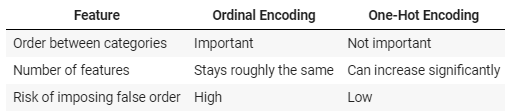

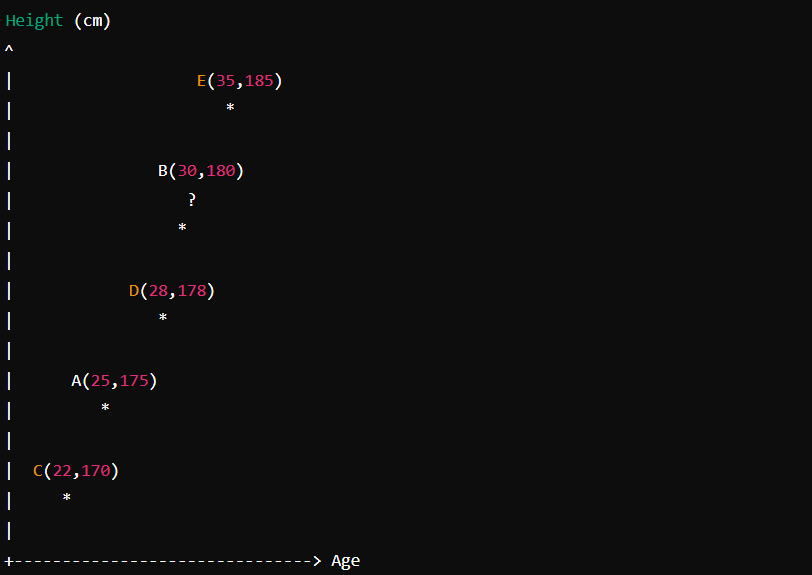

- Each '*' represents a person with known Weight.
- '?' represents Person B with missing Weight.
Steps Visualized:

- Person B (?) is missing Weight.
- We calculate distances to other known points.
Person D () is the closest neighbor, followed by Person A ().
-We use the Weights of Person D (72 kg) and Person A (70 kg) to estimate Person B's Weight as 71 kg.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer

# Assuming df is your DataFrame
df_imputeKNN = clean_names(df)

# Identify categorical and numerical columns
categorical_cols = df_imputeKNN.select_dtypes(include=['object']).columns
numeric_cols = df_imputeKNN.select_dtypes(include=[np.number]).columns

# Impute numerical columns with KNNImputer
numeric_imputer = KNNImputer(n_neighbors=5)
df_imputeKNN[numeric_cols] = numeric_imputer.fit_transform(df_imputeKNN[numeric_cols])

# Impute categorical columns with SimpleImputer
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_imputeKNN[categorical_cols] = categorical_imputer.fit_transform(df_imputeKNN[categorical_cols])

df_imputeKNN.iloc[[1207,1226],:]

In [ ]:
comparison_df = pd.DataFrame({
    'Median imputed': dfClean['price_euro'].median(),
    'Mean Imputed': dfClean['price_euro'].mean(),
    'KNN Imputed': df_imputeKNN.iloc[1226,]
}, index=['price_euro'])

comparison_df

 We **should scale your features before using the KNNImputer**. Scaling is important because the K-Nearest Neighbors (KNN) algorithm relies on distance calculations to find the nearest neighbors.
 If our features are on different scales, features with larger scales can dominate the distance calculations, which may lead to biased imputations

Why Scaling Is Important Before KNNImputer
Distance-Based Method:

- The KNNImputer uses algorithms similar to KNN classifiers or regressors, which calculate the distance between data points.
Common distance metrics (like Euclidean distance) are sensitive to the scale of the features.

- Feature Influence:Features with larger numeric ranges can disproportionately influence the distance calculation.
This can cause the imputer to consider neighbors based more on the larger-scaled features, ignoring smaller-scaled features.
Improved Imputation Accuracy:

- Scaling ensures that all features contribute equally to the distance computation.
Leads to more accurate and reliable imputations.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Assuming df is your DataFrame
df_imputeKNN_standard=df.copy()
df_imputeKNN_standard = clean_names(df_imputeKNN_standard)

# Identify categorical and numerical columns
categorical_cols = df_imputeKNN_standard.select_dtypes(include=['object']).columns
numeric_cols = df_imputeKNN_standard.select_dtypes(include=[np.number]).columns

# Impute categorical columns with SimpleImputer
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_imputeKNN_standard[categorical_cols] = categorical_imputer.fit_transform(df_imputeKNN_standard[categorical_cols])


# Scale numerical columns
scaler = StandardScaler()
df_imputeKNN_standard[numeric_cols] = scaler.fit_transform(df_imputeKNN_standard[numeric_cols])

df_imputeKNN_standard.head()

**Robust scaler**

*Standard Scaling*: Uses mean and standard deviation.

*Robust Scaling*: Uses median and interquartile range.

In [ ]:
from sklearn.preprocessing import RobustScaler

df_imputeKNN_robust=df.copy()

df_imputeKNN_robust = clean_names(df_imputeKNN_robust)

# Identify categorical and numerical columns
categorical_cols = df_imputeKNN_robust.select_dtypes(include=['object']).columns
numeric_cols = df_imputeKNN_robust.select_dtypes(include=[np.number]).columns

# Impute categorical columns with SimpleImputer
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_imputeKNN_robust[categorical_cols] = categorical_imputer.fit_transform(df_imputeKNN_robust[categorical_cols])


robust_scaler=RobustScaler()

df_imputeKNN_robust[numeric_cols] = robust_scaler.fit_transform(df_imputeKNN_robust[numeric_cols])

df_imputeKNN_robust.head()

**Displaying 2 df side by side**

In [ ]:
from IPython.display import HTML

df1_html = df_imputeKNN_standard[["weight_kg", "price_euro"]].head().to_html()
df2_html = df_imputeKNN_robust[["weight_kg", "price_euro"]].head().to_html()

display(HTML(f"""
<div style="display: flex; justify-content: space-around;">
    <div>{df1_html}</div>
    <div>{df2_html}</div>
</div>
"""))


### Using KNN on scaled dataframes to fill missing values

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer

numeric_imputer = KNNImputer(n_neighbors=5)


# Inverse transform the scaled numeric columns
df_imputeKNN_standard[numeric_cols] = pd.DataFrame(
    scaler.inverse_transform(df_imputeKNN_standard[numeric_cols]),
    columns=numeric_cols,
    index=df_imputeKNN_standard.index
)

df_imputeKNN_robust[numeric_cols] = pd.DataFrame(
    robust_scaler.inverse_transform(df_imputeKNN_robust[numeric_cols]),
    columns=numeric_cols,
    index=df_imputeKNN_robust.index
)


In [ ]:
comparison_df = pd.DataFrame({
    'Median imputed': dfClean['price_euro'].median(),
    'Mean Imputed': dfClean['price_euro'].mean(),
    'KNN Imputed without scaling': df_imputeKNN.iloc[1226,],
    'KNN Imputed with standard scaling': df_imputeKNN_standard.iloc[1226,],
    'KNN Imputed with robust scaling': df_imputeKNN_robust.iloc[1226,]
}, index=['price_euro'])

comparison_df

**In our case we only have a few price_euro missing data, thus the scaling doesnt influence the data distribution!**